In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DLD_project').getOrCreate()

In [ ]:
! gdown --id 1JlH4R3OQe_h8ANell6dNhU8I1u_dLe7F

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1JlH4R3OQe_h8ANell6dNhU8I1u_dLe7F
From (redirected): https://drive.google.com/uc?id=1JlH4R3OQe_h8ANell6dNhU8I1u_dLe7F&confirm=t&uuid=c614f9f1-3860-4780-bd27-3fc603198d31
To: /content/Transactions.csv
100% 841M/841M [00:13<00:00, 63.4MB/s]


In [ ]:
df = spark.read.csv('Transactions.csv', header=True, escape="\"")



drop columns with data in arabic and not relevant data

Also to drop:

'rent_value' as there are many null values there (more than 80%);

'meter_sale_price' as it can be calculated from 'actual_worth' and 'procedure_area'

'instance_date' - do not need this feature for a model training

'trans_group_en' - do not need this feature for a model training

'procedure_name_en' - do not need this feature for a model training

'property_usage_en' - can be dropped as already used for filtering, no need for model training

'building_name_en', 'project_name_en', 'master_project_en' - many null values, can't replace

'nearest_landmark_en' - no idea how to replace missing values

'nearest_mall_en' - a few existing options, can't replace missing values without a proper research

In [ ]:
from pyspark.sql import functions as F

In [ ]:
df_updated = df.drop('no_of_parties_role_1',
                     'no_of_parties_role_2',
                     'no_of_parties_role_3',
                     'rooms_ar',
                     'nearest_mall_ar',
                     'nearest_landmark_ar',
                     'master_project_ar',
                     'project_name_ar',
                     'building_name_ar',
                     'trans_group_ar',
                     'procedure_name_ar',
                     'property_type_ar',
                     'property_sub_type_ar',
                     'property_usage_ar',
                     'reg_type_ar',
                     'area_name_ar',
                     'nearest_metro_ar',
                     'transaction_id',
                     'procedure_id',
                     'trans_group_id',
                     'meter_rent_price',
                     'property_type_id',
                     'property_sub_type_id',
                     'reg_type_id',
                     'area_id',
                     'project_number',
                     'rent_value',
                     'meter_sale_price',
                     'instance_date',
                     'trans_group_en',
                     'procedure_name_en',
                     'property_usage_en',
                     'building_name_en',
                     'project_name_en',
                     'master_project_en',
                     'nearest_landmark_en',
                     'nearest_mall_en')

In [ ]:
df_updated.show(5,0)

+----------------+--------------------+-------------------+------------+-----------------------------+--------+-----------+--------------+------------+
|property_type_en|property_sub_type_en|reg_type_en        |area_name_en|nearest_metro_en             |rooms_en|has_parking|procedure_area|actual_worth|
+----------------+--------------------+-------------------+------------+-----------------------------+--------+-----------+--------------+------------+
|Villa           |NULL                |Existing Properties|Mankhool    |ADCB Metro Station           |NULL    |0          |1305.29       |5769000.00  |
|Land            |NULL                |Existing Properties|Al Hudaiba  |ADCB Metro Station           |NULL    |0          |1466.94       |1105300.00  |
|Villa           |NULL                |Existing Properties|Al Bada     |Emirates Towers Metro Station|NULL    |0          |390.00        |2089900.00  |
|Villa           |NULL                |Existing Properties|Al Bada     |Trade Centre Met

In [ ]:
# casting types for some columns
from pyspark.sql.types import *

df_casted = df_updated \
    .withColumn('has_parking', F.col('has_parking').cast(DoubleType())) \
    .withColumn('procedure_area', F.col('procedure_area').cast(DoubleType())) \
    .withColumn('actual_worth', F.col('actual_worth').cast(DoubleType()))

There are no null values in a 'property_type' column, but 293518 null values in 'property_sub_type'. We can replace null values in 'property_sub_type' with values from 'property_type'

In [ ]:
df_casted.filter(df_casted['property_sub_type_en'].isNull()).count()

293518

In [ ]:
df_casted.select('property_type_en').distinct().show()

+----------------+
|property_type_en|
+----------------+
|           Villa|
|            Land|
|            Unit|
|        Building|
+----------------+



In [ ]:
# replace null values in sub_types with the main property type
df_casted = df_casted.withColumn(
    'property_sub_type_en',
    F.when(F.col('property_sub_type_en').isNull(), F.col('property_type_en')).otherwise(F.col('property_sub_type_en'))
)

In [ ]:
df_casted.select('property_sub_type_en').distinct().show()

+--------------------+
|property_sub_type_en|
+--------------------+
|             Parking|
|     Hotel Apartment|
|              Office|
|                Flat|
|  Stacked Townhouses|
|                Shop|
|               Villa|
|            Workshop|
|                Land|
|           Gymnasium|
|               Store|
|               Hotel|
|           Warehouse|
|     Sized Partition|
|              Clinic|
|         Hotel Rooms|
|          Show Rooms|
|            Building|
+--------------------+



To optimize and minimize the dataset, remove commercial properties and land, retaining only residential properties (Flat, Hotel Apartment, Villa, Hotel Rooms, townhouses, etc.).

In [ ]:
# number of row before removing commercial properties
df_casted.count()

1372761

In [ ]:
# filtering, leaving only residential types without Land
df_res = df_casted.filter(
    (F.col('property_usage_en') == 'Residential') &
    (F.col('property_type_en') != 'Land')
)

In [ ]:
# number of rows of dataset containing only residental prolerties without Land
df_res.count()

1106675

In [ ]:
df_res.select('property_type_en').distinct().show()

+----------------+
|property_type_en|
+----------------+
|           Villa|
|            Unit|
|        Building|
+----------------+



In [ ]:
df_res.select('property_sub_type_en').distinct().show()

+--------------------+
|property_sub_type_en|
+--------------------+
|                Flat|
|  Stacked Townhouses|
|               Villa|
|            Building|
+--------------------+



In [ ]:
df_res.groupBy('property_type_en').count().show()

+----------------+------+
|property_type_en| count|
+----------------+------+
|           Villa|254713|
|            Unit|839539|
|        Building| 12423|
+----------------+------+



In [ ]:
df_res.groupBy('property_sub_type_en').count().show()

+--------------------+------+
|property_sub_type_en| count|
+--------------------+------+
|                Flat|839071|
|  Stacked Townhouses|   468|
|               Villa|254713|
|            Building| 12423|
+--------------------+------+



Imbalanced datasets because there are a few classes with much more data than others. Townhouses category is very small and doesn't provide useful predictive power => exclude it to simplify the model. Moreover, the townhouses that are presented in a dataset are all located in one area "Madinat Al Mataar", so this data is not representative.
The same solution for Buidings.

In [ ]:
df_res = df_res.filter((df_res.property_sub_type_en != 'Building') & (df_res.property_sub_type_en != 'Stacked Townhouses'))

In [ ]:
df_res.groupBy('property_sub_type_en').count().show()

+--------------------+------+
|property_sub_type_en| count|
+--------------------+------+
|                Flat|839071|
|               Villa|254713|
+--------------------+------+



In [ ]:
# helper function to calculate and print number of null values, and number of distinct values in every column of dataset
def get_col_info(df, cols):
    for c in cols:
        nulls = df.filter(df[c].isNull()).count()
        dist = df.select(c).distinct().count()
        print(f'{c}: null values={nulls}; distinct values={dist}')

get_col_info(df_res, df_res.columns)

property_sub_type_en: null values=0; distinct values=2
reg_type_en: null values=0; distinct values=2
area_name_en: null values=0; distinct values=133
nearest_metro_en: null values=0; distinct values=2
rooms_en: null values=134425; distinct values=13
has_parking: null values=0; distinct values=2
procedure_area: null values=0; distinct values=56138
actual_worth: null values=0; distinct values=234517


There are **134 425** null values in 'rooms_en' column.

Solution for replacing null values in 'rooms_en' column: calculate the average area for each room type and use the corresponding average value to fill in the missing entries

In [ ]:
df_res.select('rooms_en').distinct().show()

+-----------+
|   rooms_en|
+-----------+
|      4 B/R|
|Single Room|
|     Studio|
|      5 B/R|
|      8 B/R|
|      6 B/R|
|  PENTHOUSE|
|      3 B/R|
|      2 B/R|
|      7 B/R|
|      9 B/R|
|      1 B/R|
|       NULL|
+-----------+



Remove types (Shop, Office) not related to 'residential property' scope.

In [ ]:
df_res = df_res.filter(
    (F.col('rooms_en').isNull()) |  # keep null values
    ((F.col('rooms_en') != 'Office') & (F.col('rooms_en') != 'Shop'))  # keep rows that are not Shop or Office
)

In [ ]:
df_res.select('rooms_en').distinct().show()

+-----------+
|   rooms_en|
+-----------+
|      4 B/R|
|Single Room|
|     Studio|
|      5 B/R|
|      8 B/R|
|      6 B/R|
|  PENTHOUSE|
|      3 B/R|
|      2 B/R|
|      7 B/R|
|      9 B/R|
|      1 B/R|
|       NULL|
+-----------+



In [ ]:
# calculate the average area for each room type
avg_area_df = df_res.filter(df_res['rooms_en'].isNotNull()) \
                    .groupBy('rooms_en') \
                    .agg(F.avg('procedure_area').alias('avg_area'))

# sort avg_area_df for further processing
avg_area_df_sorted = avg_area_df.orderBy(F.desc('avg_area'))
avg_area_df_sorted.show()

+-----------+------------------+
|   rooms_en|          avg_area|
+-----------+------------------+
|      9 B/R|          2828.515|
|      7 B/R|1583.0283333333334|
|      6 B/R|1049.9902554744526|
|      8 B/R| 801.8000000000001|
|      5 B/R| 518.8067733990149|
|  PENTHOUSE|344.31973840665876|
|      4 B/R|327.52280948801814|
|      3 B/R|219.18291627881527|
|      2 B/R|131.87911753604675|
|      1 B/R| 77.07534010943839|
|     Studio|43.728562335340605|
|Single Room|11.600964467005078|
+-----------+------------------+



In [ ]:
# prepare arrays for further processing
data = avg_area_df_sorted.collect()
rooms_types = [row['rooms_en'] for row in data]
avg_areas = [row['avg_area'] for row in data]
print(rooms_types)
print(avg_areas)

['9 B/R', '7 B/R', '6 B/R', '8 B/R', '5 B/R', 'PENTHOUSE', '4 B/R', '3 B/R', '2 B/R', '1 B/R', 'Studio', 'Single Room']
[2828.515, 1583.0283333333334, 1049.9902554744526, 801.8000000000001, 518.8067733990149, 344.31973840665876, 327.52280948801814, 219.18291627881527, 131.87911753604675, 77.07534010943839, 43.728562335340605, 11.600964467005078]


In [ ]:
# fill null values with corresponding average value by number of rooms
def assign_room_type(area):
    if area is None:
        return rooms_types[-1]
    for avg_area, room_type in zip(avg_areas, rooms_types):
        if area > avg_area:
            return room_type
    return rooms_types[-1]

In [ ]:
# for testing
print(assign_room_type(44.67))

Studio


In [ ]:
# assign user defined function
assign_room_type_udf = F.udf(assign_room_type, StringType())

# update dataset filling null values in 'rooms_en' column
df_res = df_res.withColumn(
    'rooms_en',
    F.when(F.col('rooms_en').isNull(), assign_room_type_udf(F.col('procedure_area')))
    .otherwise(F.col('rooms_en'))
)

In [ ]:
df_res.filter(df_res['rooms_en'].isNull()).count()

0

There are **270 424** null values in 'nearest_metro_en' column.


Solution for replacing null values in 'nearest_metro_en' column: assign a value of 0 for nulls (indicating no metro nearby) and a value of 1 for existing string values (indicating a metro station is nearby)

In [ ]:
df_res = df_res.withColumn(
    'nearest_metro_en',
    F.when(F.col('nearest_metro_en').isNull(), 0)
    .otherwise(1)
)

In [ ]:
df_res = df_res.withColumn('nearest_metro_en', F.col('nearest_metro_en').cast(DoubleType()))

In [ ]:
# drop column 'property_type_en' as we are planning to use property subtype for training
df_res = df_res.drop('property_type_en')

In [ ]:
df_res.show(10)

+--------------------+-------------------+------------+----------------+---------+-----------+--------------+------------+
|property_sub_type_en|        reg_type_en|area_name_en|nearest_metro_en| rooms_en|has_parking|procedure_area|actual_worth|
+--------------------+-------------------+------------+----------------+---------+-----------+--------------+------------+
|               Villa|Existing Properties|    Mankhool|             1.0|    6 B/R|        0.0|       1305.29|   5769000.0|
|               Villa|Existing Properties|     Al Bada|             1.0|PENTHOUSE|        0.0|         390.0|   2089900.0|
|               Villa|Existing Properties|     Al Bada|             1.0|PENTHOUSE|        0.0|        396.09|    511612.0|
|               Villa|Existing Properties|     Al Bada|             1.0|PENTHOUSE|        0.0|        362.32|   1500000.0|
|               Villa|Existing Properties|    Al Satwa|             1.0|    3 B/R|        0.0|        239.23|   3000000.0|
|               

**Data Analysis**

In [ ]:
df_res.select("actual_worth").describe().show()

+-------+------------------+
|summary|      actual_worth|
+-------+------------------+
|  count|           1093739|
|   mean|1909729.5830751213|
| stddev| 4723449.052561656|
|    min|               1.0|
|    max|     3.013326074E9|
+-------+------------------+



In [ ]:
quantiles = df_res.approxQuantile("actual_worth", [0.25, 0.5, 0.75], 0.01)
print(f"25th percentile: {quantiles[0]}, Median (50th percentile): {quantiles[1]}, 75th percentile: {quantiles[2]}")

25th percentile: 690000.0, Median (50th percentile): 1226888.0, 75th percentile: 2200000.0




Skewness: the difference between the median (1.22 million) and the 75th percentile (2.2 million) is significant, indicating that the data is skewed. Additionally, if we compare the 25th percentile (690 000) and median (1.2 million), the median is much higher than the 25th percentile, suggesting that most of the data is clustered towards the lower end, and the tail on the higher end is longer => positively skewed distribution.

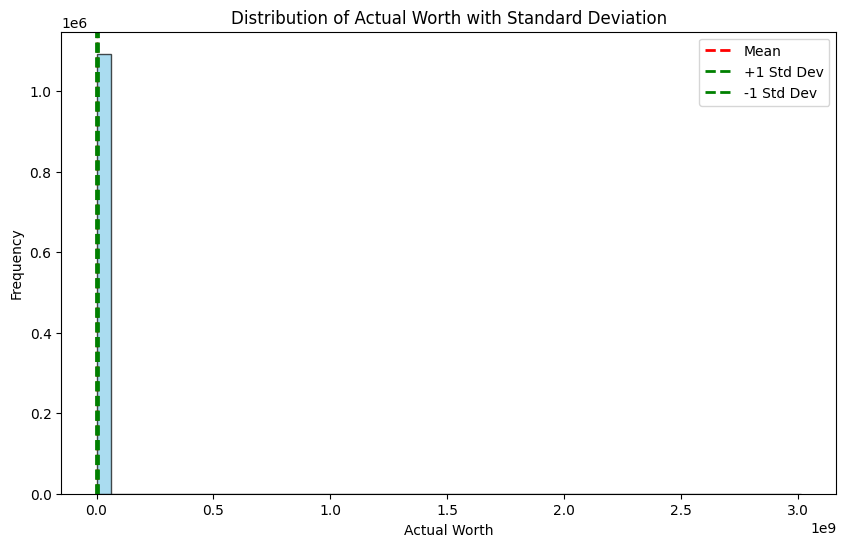

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_pd = df_res.select("actual_worth").toPandas()

mean_value = df_pd["actual_worth"].mean()
std_dev = df_pd["actual_worth"].std()

plt.figure(figsize=(10, 6))
plt.hist(df_pd["actual_worth"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_dev, color='green', linestyle='dashed', linewidth=2, label='+1 Std Dev')
plt.axvline(mean_value - std_dev, color='green', linestyle='dashed', linewidth=2, label='-1 Std Dev')

plt.title('Distribution of Actual Worth with Standard Deviation')
plt.xlabel('Actual Worth')
plt.ylabel('Frequency')
plt.legend()

plt.show()

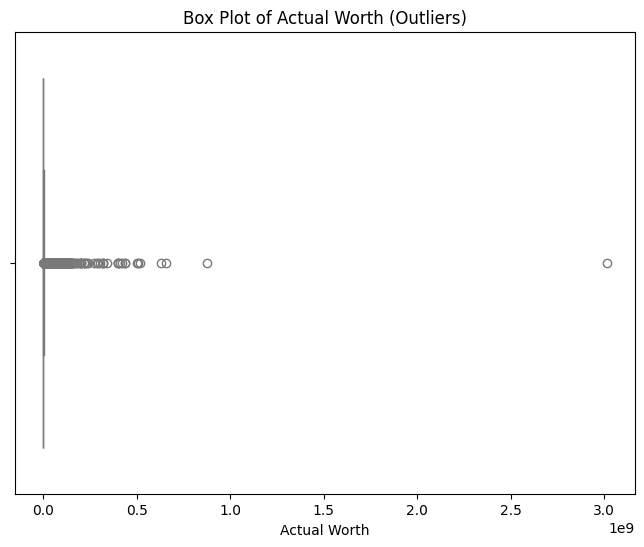

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_pd, x="actual_worth", color='lightblue')

plt.title('Box Plot of Actual Worth (Outliers)')
plt.xlabel('Actual Worth')

plt.show()

Max value 3.013326074E9 and min value 1 are outliners.

In [ ]:
# clean data, removing outliners
quantiles = df_res.approxQuantile("actual_worth", [0.02, 0.98], 0.01)
lower_percentile, upper_percentile = quantiles[0], quantiles[1]

cleaned_df = df_res.filter((F.col("actual_worth") >= lower_percentile) & (F.col("actual_worth") <= upper_percentile))

cleaned_df.select("actual_worth").describe().show()

+-------+------------------+
|summary|      actual_worth|
+-------+------------------+
|  count|           1052235|
|   mean|1616559.6909815774|
| stddev|1271538.3051492632|
|    min|          250000.0|
|    max|         7706100.0|
+-------+------------------+



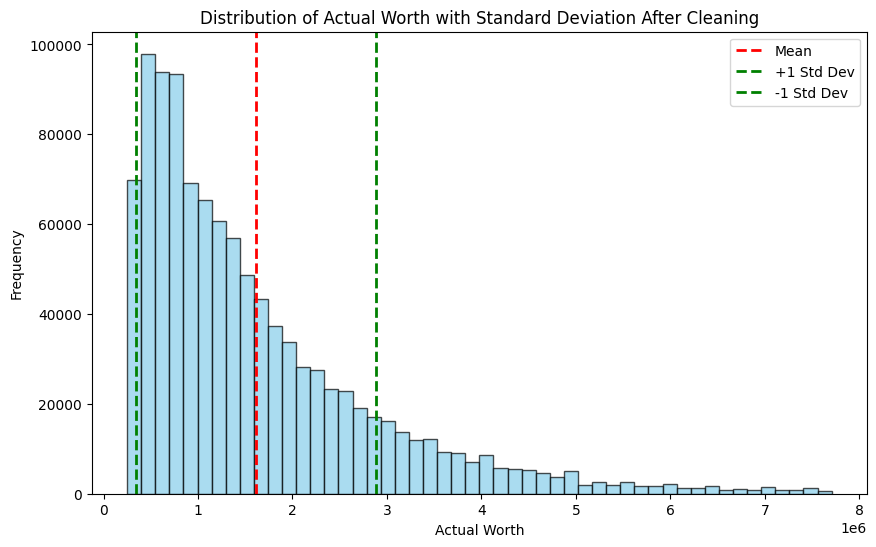

In [ ]:
cleaned_df_pd = cleaned_df.select("actual_worth").toPandas()

mean_value = cleaned_df_pd["actual_worth"].mean()
std_dev = cleaned_df_pd["actual_worth"].std()

plt.figure(figsize=(10, 6))
plt.hist(cleaned_df_pd["actual_worth"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_dev, color='green', linestyle='dashed', linewidth=2, label='+1 Std Dev')
plt.axvline(mean_value - std_dev, color='green', linestyle='dashed', linewidth=2, label='-1 Std Dev')

plt.title('Distribution of Actual Worth with Standard Deviation After Cleaning')
plt.xlabel('Actual Worth')
plt.ylabel('Frequency')
plt.legend()

plt.show()

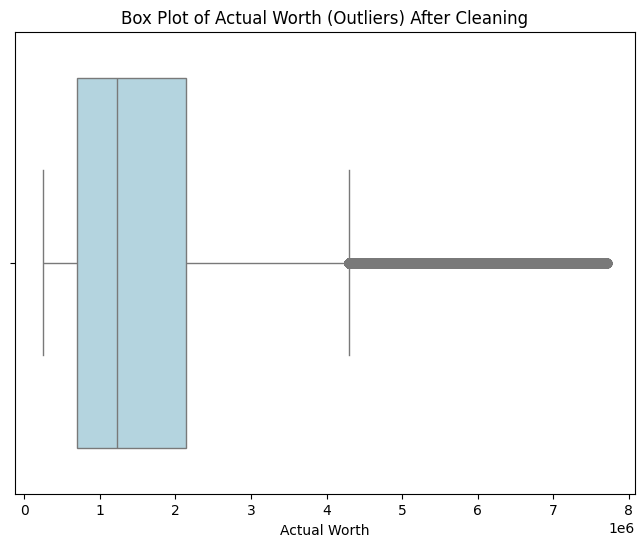

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=cleaned_df_pd, x="actual_worth", color='lightblue')

plt.title('Box Plot of Actual Worth (Outliers) After Cleaning')
plt.xlabel('Actual Worth')

plt.show()

In [ ]:
cleaned_df.select("procedure_area").describe().show()
quantiles_area = cleaned_df.approxQuantile("procedure_area", [0.25, 0.5, 0.75], 0.01)
print(f"25th percentile: {quantiles_area[0]}, Median (50th percentile): {quantiles_area[1]}, 75th percentile: {quantiles_area[2]}")

+-------+------------------+
|summary|    procedure_area|
+-------+------------------+
|  count|           1052235|
|   mean|192.72378886845792|
| stddev| 287.0496876698436|
|    min|              0.01|
|    max|          55362.94|
+-------+------------------+

25th percentile: 68.69, Median (50th percentile): 104.67, 75th percentile: 180.42


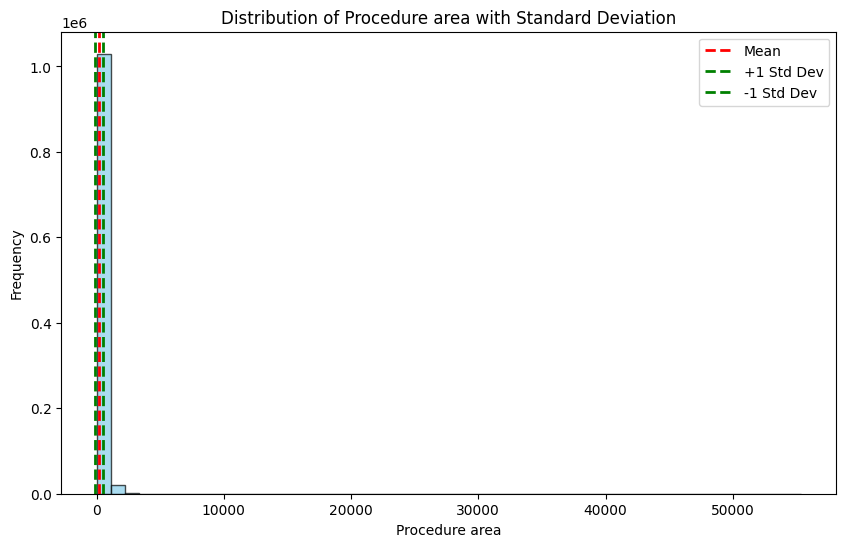

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_pd = cleaned_df.select("procedure_area").toPandas()

mean_value = df_pd["procedure_area"].mean()
std_dev = df_pd["procedure_area"].std()

plt.figure(figsize=(10, 6))
plt.hist(df_pd["procedure_area"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_dev, color='green', linestyle='dashed', linewidth=2, label='+1 Std Dev')
plt.axvline(mean_value - std_dev, color='green', linestyle='dashed', linewidth=2, label='-1 Std Dev')

plt.title('Distribution of Procedure area with Standard Deviation')
plt.xlabel('Procedure area')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [ ]:
quantiles_area = cleaned_df.approxQuantile("procedure_area", [0.02, 0.90], 0.01)
lower_percentile, upper_percentile = quantiles_area[0], quantiles_area[1]
filtered_df = cleaned_df.filter((F.col("procedure_area") >= lower_percentile) & (F.col("procedure_area") <= upper_percentile))
filtered_df.select("procedure_area").describe().show()

+-------+-----------------+
|summary|   procedure_area|
+-------+-----------------+
|  count|           922533|
|   mean|118.2313090263434|
| stddev|72.12366714992025|
|    min|             34.5|
|    max|           385.36|
+-------+-----------------+



In [ ]:
filtered_df.count()

922533

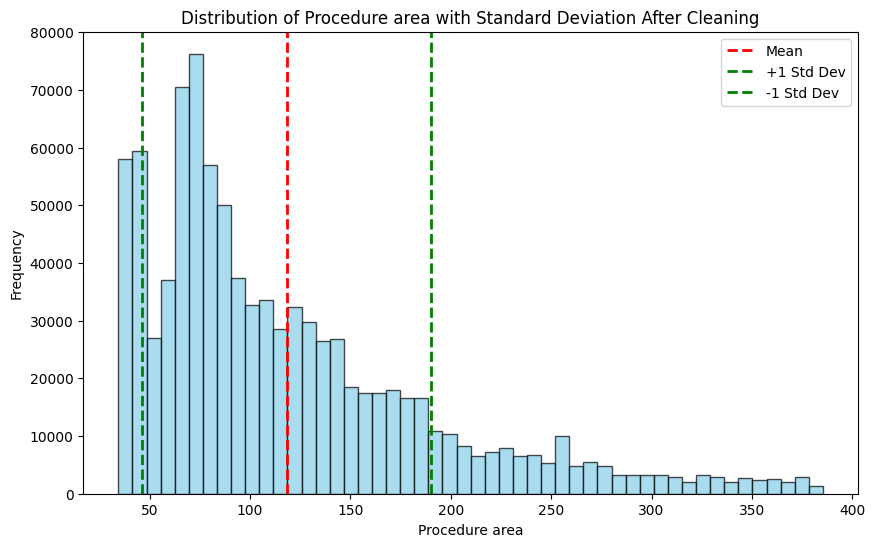

In [ ]:
filtered_df_pd = filtered_df.select("procedure_area").toPandas()

mean_value = cleaned_df_pd["procedure_area"].mean()
std_dev = cleaned_df_pd["procedure_area"].std()

plt.figure(figsize=(10, 6))
plt.hist(cleaned_df_pd["procedure_area"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_dev, color='green', linestyle='dashed', linewidth=2, label='+1 Std Dev')
plt.axvline(mean_value - std_dev, color='green', linestyle='dashed', linewidth=2, label='-1 Std Dev')

plt.title('Distribution of Procedure area with Standard Deviation After Cleaning')
plt.xlabel('Procedure area')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [ ]:
area_counts = filtered_df.groupBy('area_name_en').count()
area_counts.show()

+--------------------+-----+
|        area_name_en|count|
+--------------------+-----+
|    Um Hurair Second|  177|
|        Al Rashidiya|  585|
|         Al Khabeesi|    3|
|Al Barsha South F...| 9668|
|          Al Kheeran|  914|
|      Al Twar Second|   13|
|     Um Suqaim First|   23|
|  Nad Al Shiba First| 5158|
|       Al Yelayiss 1| 9968|
|       Saih Shuaib 2|  861|
|Al Barsha South F...|71945|
|        Business Bay|58820|
|             Al Wasl| 8569|
|Dubai Investment ...| 4918|
|     Um Suqaim Third| 3549|
|       Zaabeel First| 1853|
|   Madinat Al Mataar|17872|
|              Mirdif| 2459|
|             Al Bada|  377|
|         Al Yufrah 1| 6023|
+--------------------+-----+
only showing top 20 rows



In [ ]:
unique_areas_count = filtered_df.select('area_name_en').distinct().count()
print(f'number of areas before filtering: {unique_areas_count}')

area_df = filtered_df.groupBy('area_name_en').count().filter('count > 5')
print(f'number of areas after filtering: {area_df.count()}')

number of areas before filtering: 121
number of areas after filtering: 108


In [ ]:
areas_to_keep = area_df.select('area_name_en')

In [ ]:
print(f'Number of rows before filtering: {filtered_df.count()}')

updated_df = filtered_df.join(areas_to_keep, on='area_name_en', how='inner')
print(f'Number of rows after filtering: {updated_df.count()}')

Number of rows before filtering: 922533
Number of rows after filtering: 922507


In [ ]:
updated_df.write.format("parquet").mode("overwrite").save("/content/drive_new/MyDrive/cleaned_dataset")

In [ ]:
from google.colab import drive
drive.mount('/content/drive_new')

In [ ]:
cleaned_df.write.format("parquet").mode("overwrite").save("/content/drive_new/MyDrive/cleaned_dataset")